# Analysis of EOD simulations of BSE detection in HR and UHR-mode
---

#### Overview
Seek to explain what detection looks like as a function of both landing energy (LE) and stage bias (SB). Also would like to see the saturation effect manifest itself. At this point, pretty much convinced that SE's don't play a role and go completely undetected. So will simulate only BSE's with energy corresponding to the LE being simulated.

Main idea is to gather BSE trajectories over a range of BSE energies and stage biases in both HR and UHR mode. Key to this is also having the kinetic energy of the BSE as it hits the detector

In [1]:
from pathlib import Path
from textwrap import dedent
import subprocess
from itertools import product
from multiprocessing import Pool

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import altair as alt

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## Visualizing BSE trajectories
---

### Render simulation environment

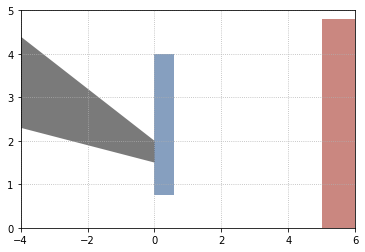

In [253]:
# CBS detector plane
Z0 = 0.57

# EOD element outlines
elements = {
    'CBS_detector': [[0.00, 4.00],
                     [  Z0, 4.00],
                     [  Z0, 0.75],
                     [0.00, 0.75]],
    'polepiece': [[-5.00, 5.00],
                  [ 0.00, 2.00],
                  [ 0.00, 1.50],
                  [-5.00, 2.50]],
    'stage': [[ 5.00, 4.80],
              [10.00, 4.80],
              [10.00, 0.00],
              [ 5.00, 0.00]]
}

# Create patches
patches = []
for element, coords in elements.items():
    polygon = Polygon(coords)
    patches.append(polygon)

# Make PatchCollection
cmap = sns.diverging_palette(250, 15, s=75, l=40, center='dark', as_cmap=True)
pc = PatchCollection(patches, cmap=cmap, alpha=0.6)
colors = np.arange(len(patches))
pc.set_array(colors)

# Make figure
fig, ax = plt.subplots()
ax.add_collection(pc)
# Figure aesthetics
ax.set_xlim(-4, 6)
ax.set_ylim(0, 5)
ax.grid(ls=':')

### Load trajectory data

In [5]:
fp = Path('DATA/BSE_trajectories.csv')
df_trj = pd.read_csv(fp)
df_trj.sample(10)

,i,Z,R,K,mode,E0,SB,theta
13969,37,1.691424,2.179897,1961.478559,HR,500,2000,52.897070
45168,75,2.369762,1.442541,1790.117240,HR,1500,500,30.199416
92654,17,1.778340,4.417606,4933.490426,HR,3000,3000,66.243159
30536,16,3.985305,1.717808,1333.449460,HR,1000,1500,67.036558
82576,41,-1.481544,6.937893,3375.433171,HR,3000,500,50.521200
214683,67,0.823638,1.943845,2438.573917,UHR,1500,1000,35.284644
185314,13,1.345748,2.704256,3419.142566,UHR,1000,3000,69.559065
240863,8,20.195376,2.525571,2000.000009,UHR,2000,0,74.483398
83919,99,-88.883790,4.612739,3499.995259,HR,3000,500,6.042459
67522,99,-51.104064,4.683114,3000.000745,HR,2000,1000,6.042459


### Plot BSE trajectories | HR-mode

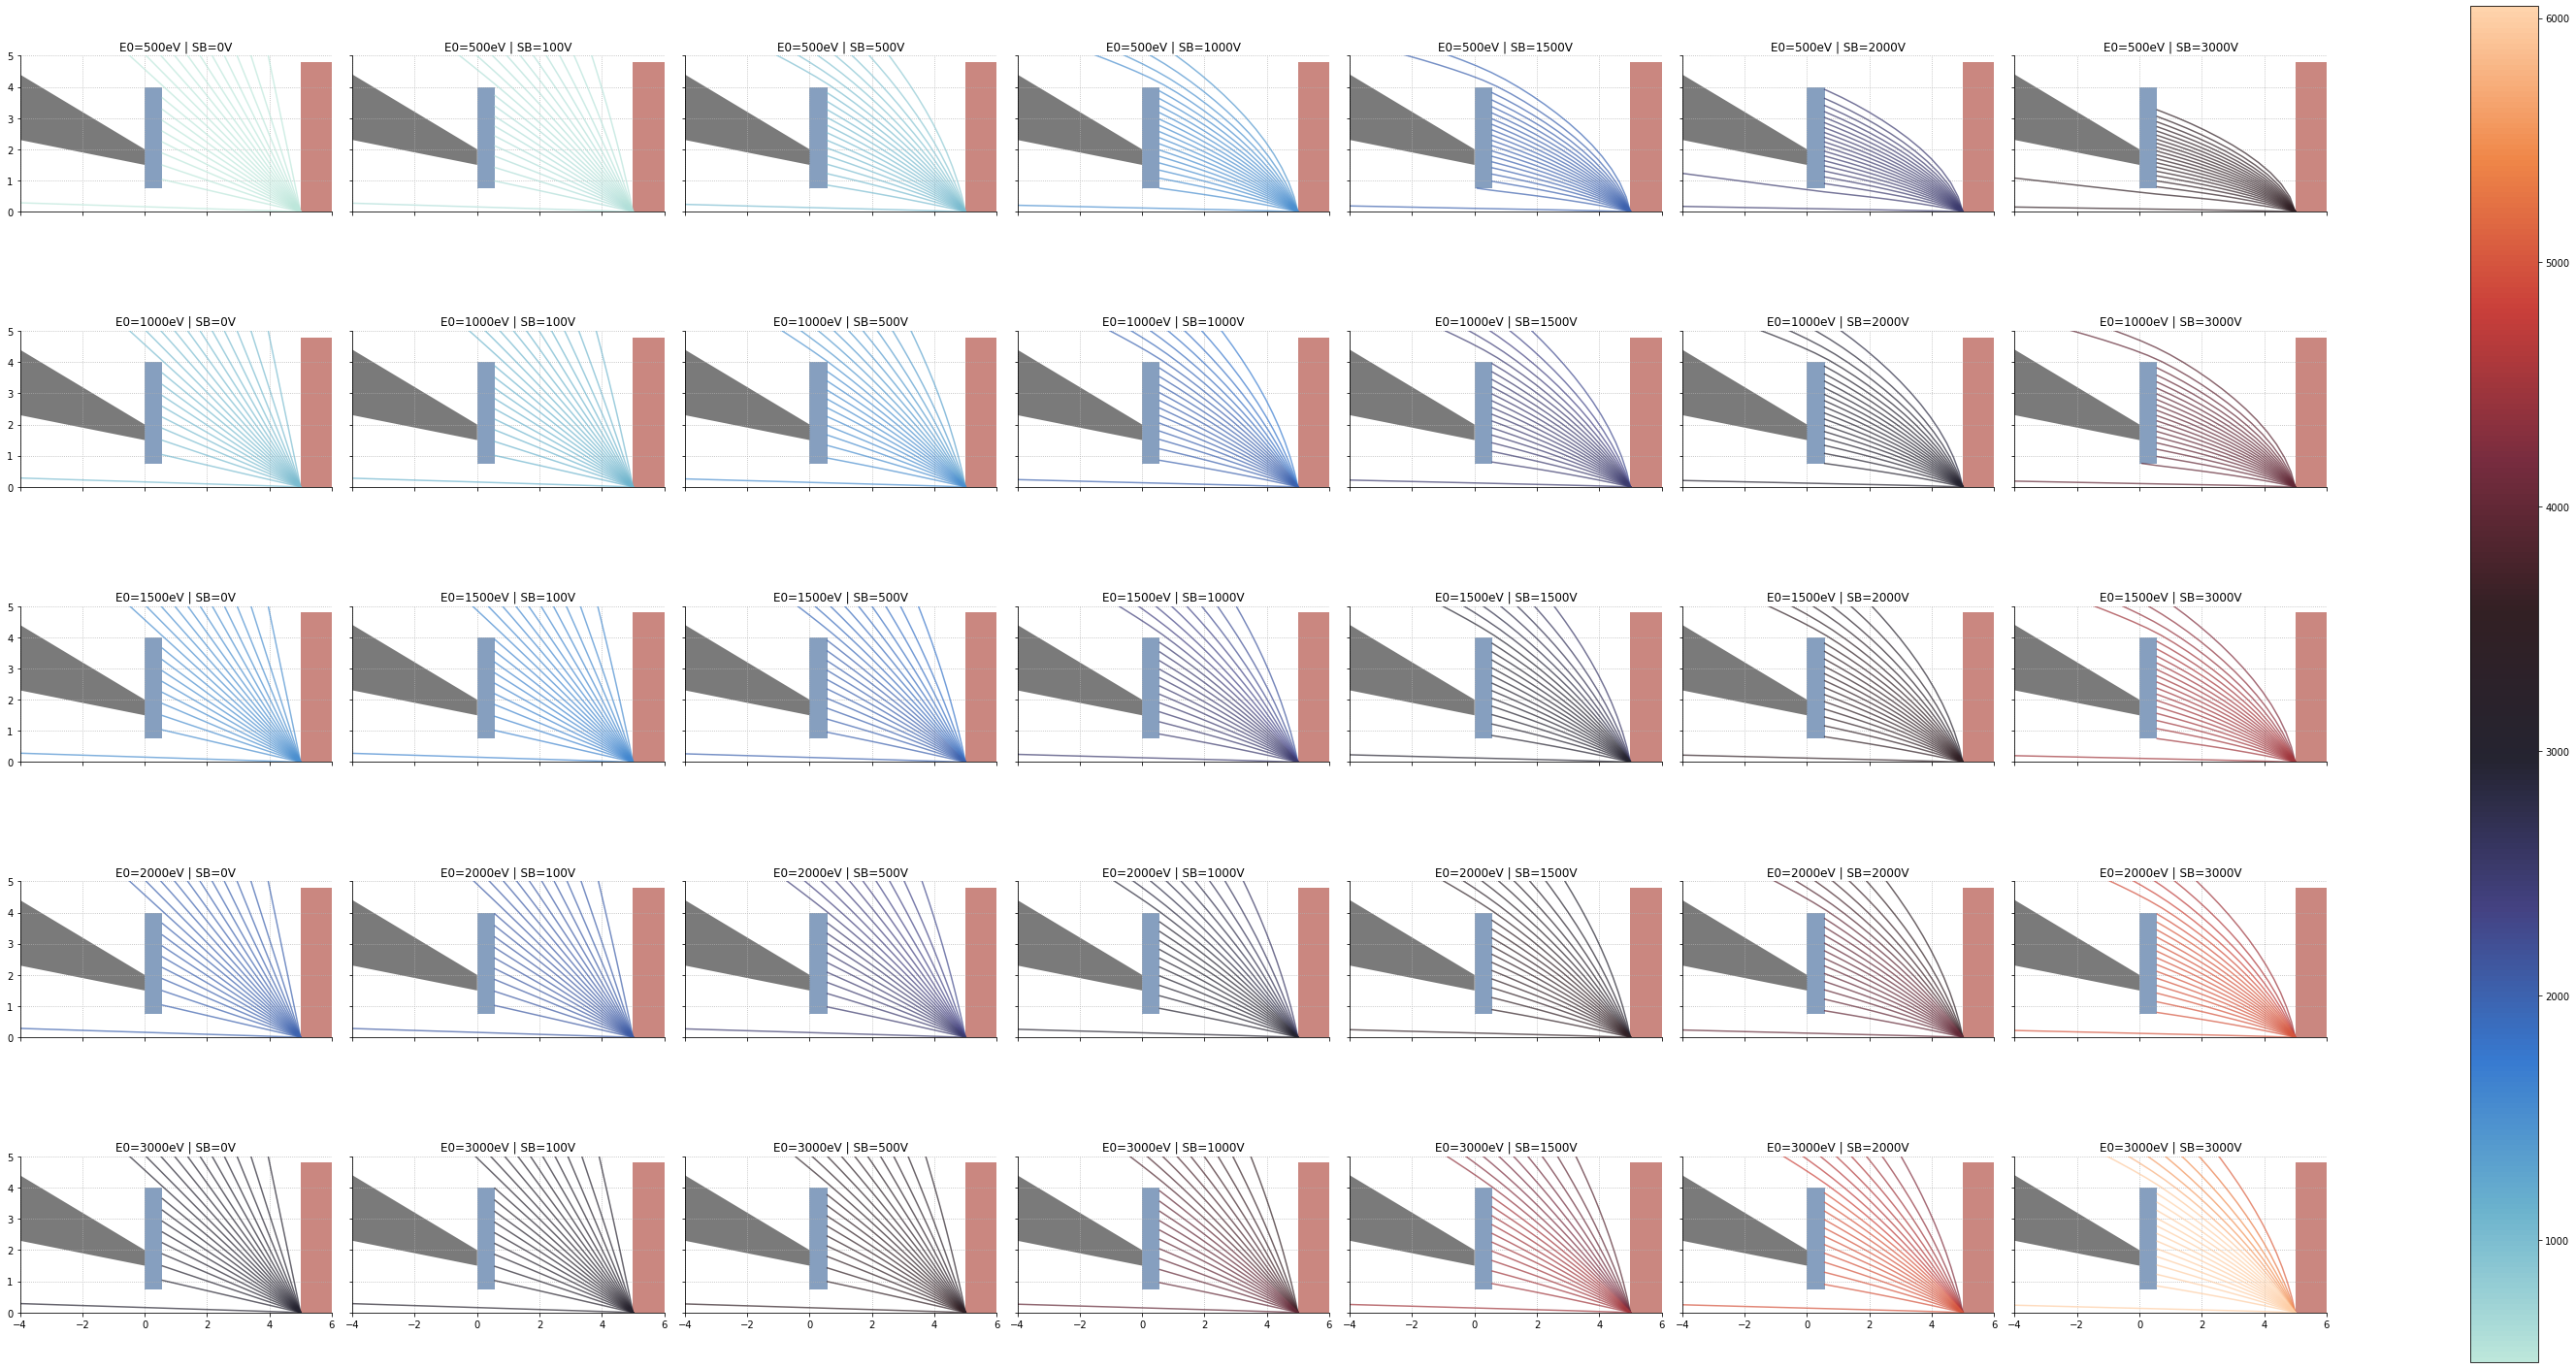

In [137]:
# ----------------
# Set up FacetGrid
# ----------------
source = df_trj.loc[df_trj['mode'] == 'HR']
g = sns.FacetGrid(source, row='E0', col='SB', height=4, aspect=1.5)
colors = sns.cm.icefire(np.linspace(0, 1, 10))
cmap = sns.blend_palette(colors, as_cmap=True)

# ---------------------
# Plot BSE trajectories
# ---------------------
K_min = source.groupby(['E0', 'SB', 'i'])['K'].apply(lambda x: x.iloc[-1]).min()
K_max = source.groupby(['E0', 'SB', 'i'])['K'].apply(lambda x: x.iloc[-1]).max()
for j, ((E0, SB), grp) in enumerate(source.groupby(['E0', 'SB'])):
    # Choose axis
    ax = g.axes.flat[j]
    # Iterate through particles
    for i, particle in grp.groupby('i'):
        if not i % 5:  # only plot every nth BSE trajectory
            K_f = particle['K'].iloc[-1]  # Final KE of particle i
            K_rel = (K_f - K_min) / (K_max - K_min)  # Scale final KE
            ax.plot(particle['Z'], particle['R'], color=cmap(K_rel), alpha=0.7)
    # Aesthetics
    title = f'E0={E0}eV | SB={SB}V'
    ax.set_title(title)
    ax.set_xlim(-4, 6)
    ax.set_ylim(0, 5)
    ax.set_aspect('equal')
    ax.grid(ls=':')
# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=K_min, vmax=K_max))
g.fig.colorbar(sm, ax=g.axes.ravel())

# ---------------------------------
# Add sample <--> detector geometry
# ---------------------------------
for ax in g.axes.flat:
    # Create patches
    patches = []
    for element, coords in elements.items():
        polygon = Polygon(coords)
        patches.append(polygon)
    # Make PatchCollection
    cmap = sns.diverging_palette(250, 15, s=75, l=40, center='dark', as_cmap=True)
    pc = PatchCollection(patches, cmap=cmap, alpha=0.6)
    colors = np.arange(len(patches))
    pc.set_array(colors)
    # Plot onto figure
    ax.add_collection(pc)

### Plot BSE trajectories | UHR-mode

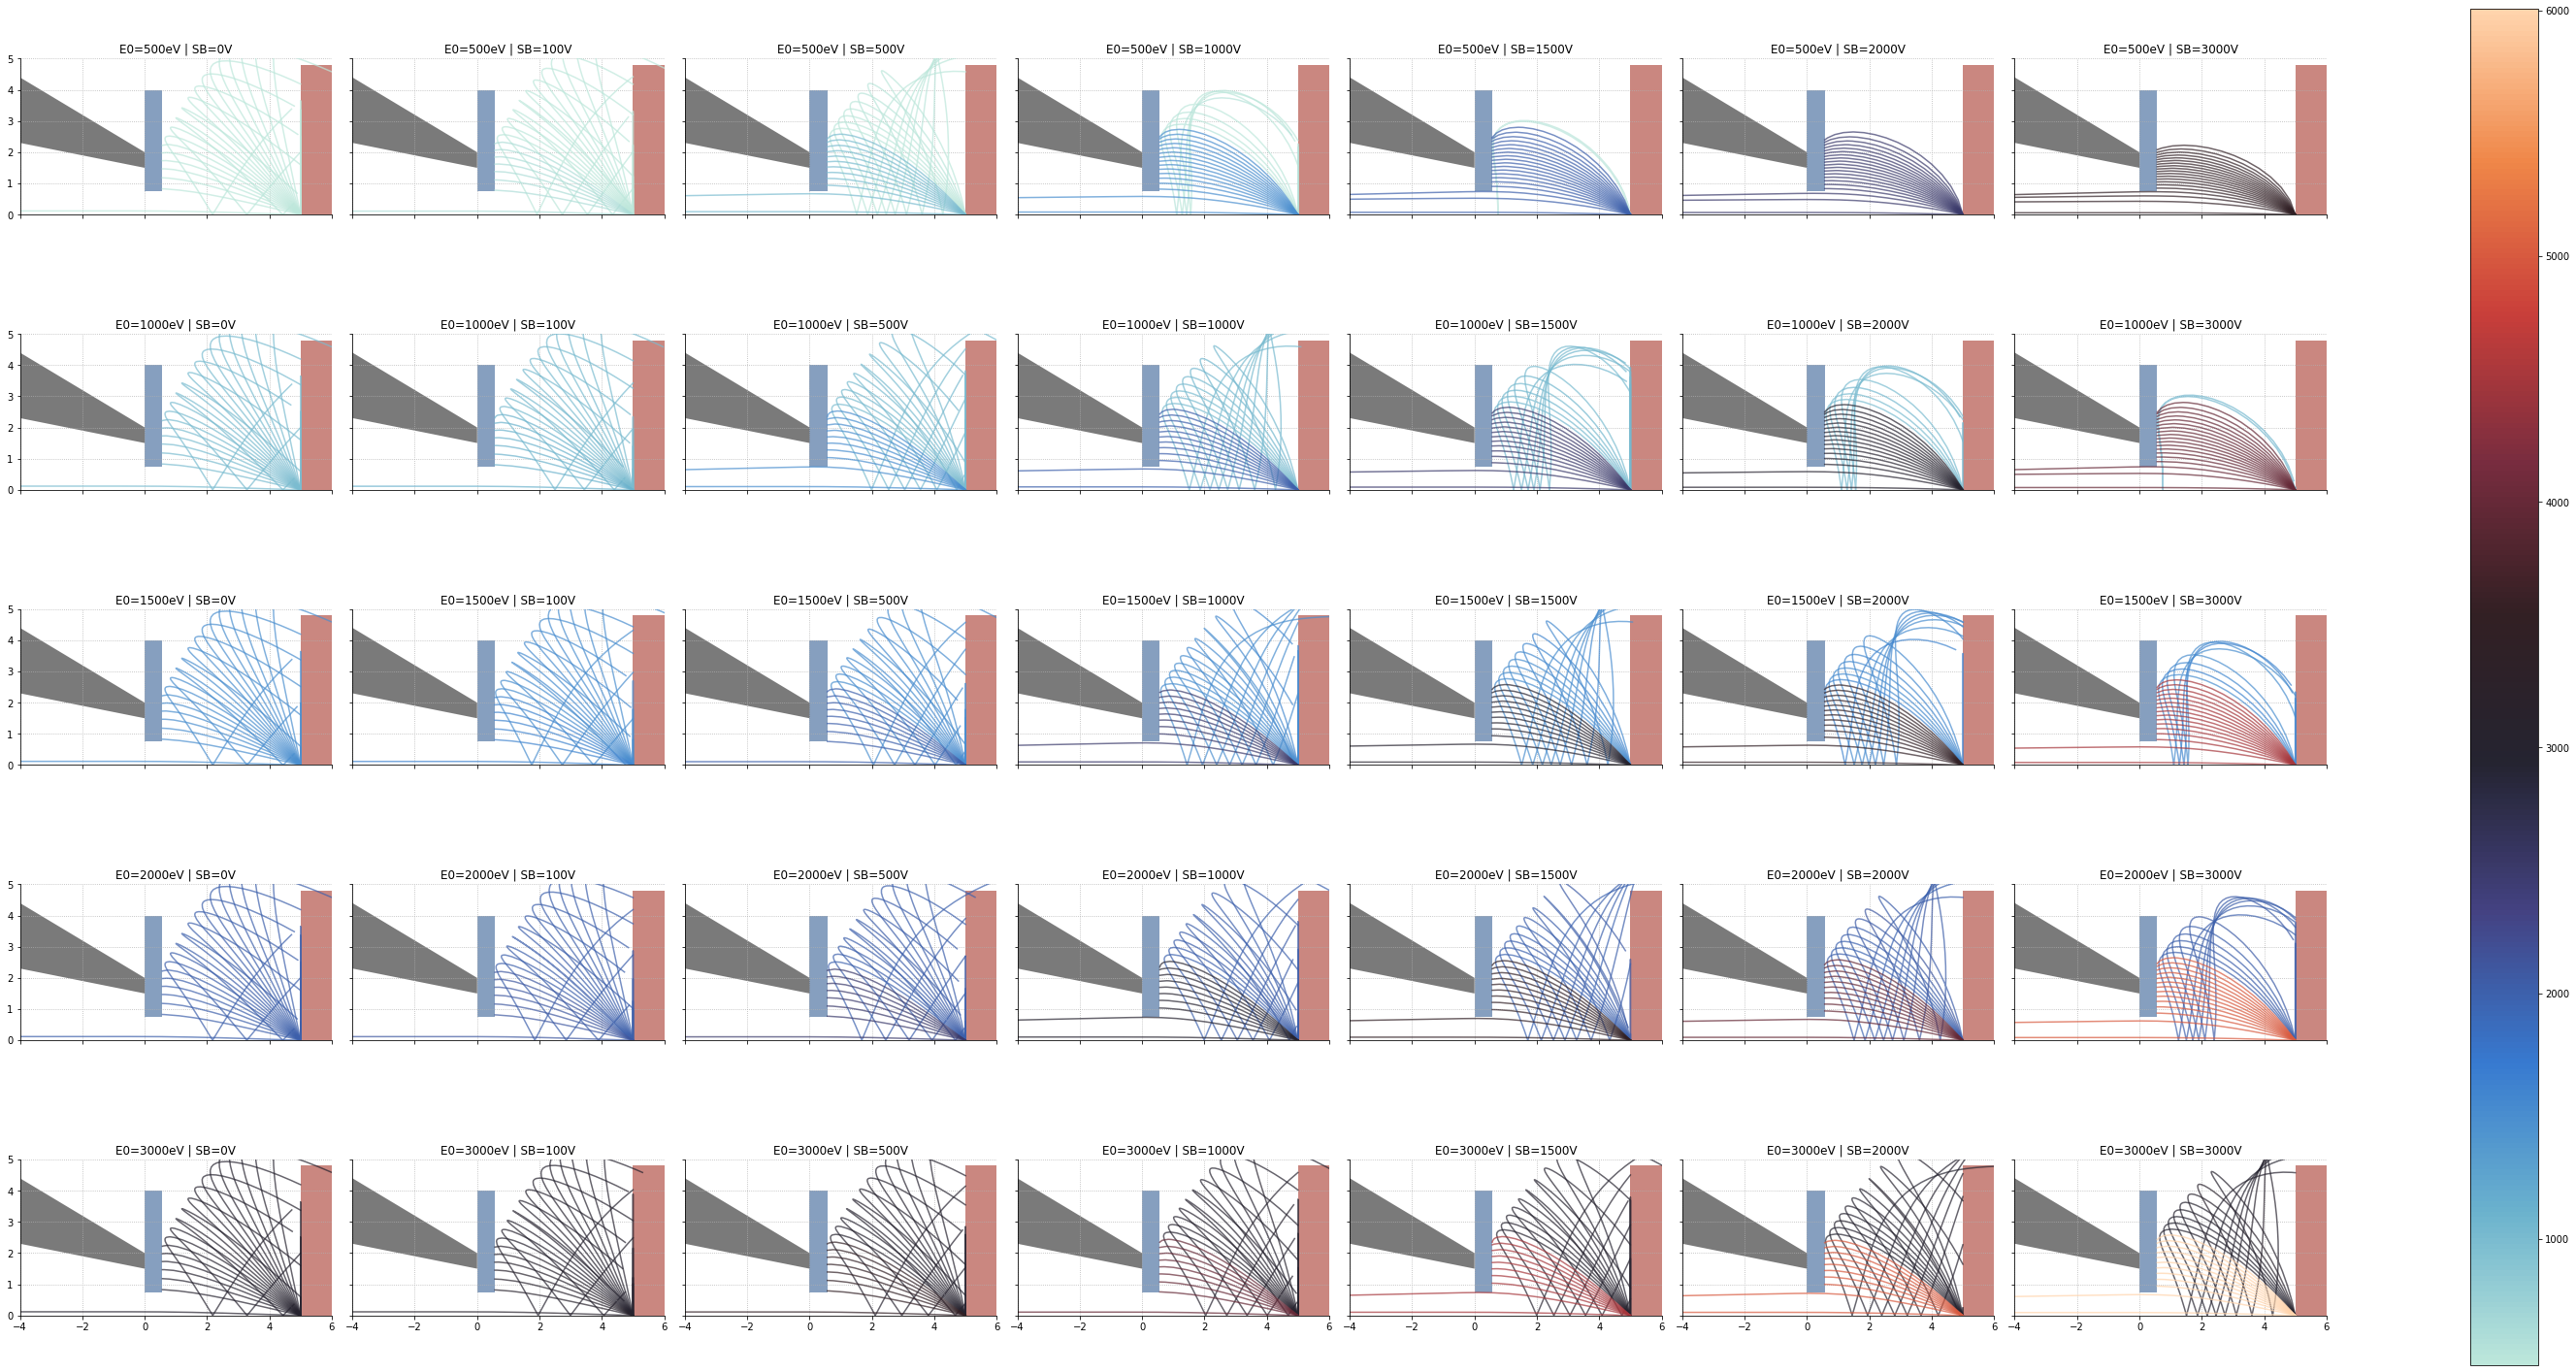

In [136]:
# ----------------
# Set up FacetGrid
# ----------------
source = df_trj.loc[df_trj['mode'] == 'UHR']
g = sns.FacetGrid(source, row='E0', col='SB', height=4, aspect=1.5)
colors = sns.cm.icefire(np.linspace(0, 1, 10))
cmap = sns.blend_palette(colors, as_cmap=True)

# ---------------------
# Plot BSE trajectories
# ---------------------
K_min = source.groupby(['E0', 'SB', 'i'])['K'].apply(lambda x: x.iloc[-1]).min()
K_max = source.groupby(['E0', 'SB', 'i'])['K'].apply(lambda x: x.iloc[-1]).max()
for j, ((E0, SB), grp) in enumerate(source.groupby(['E0', 'SB'])):
    # Choose axis
    ax = g.axes.flat[j]
    # Iterate through particles
    for i, particle in grp.groupby('i'):
        if not i % 5:  # only plot every nth BSE trajectory
            K_f = particle['K'].iloc[-1]  # Final KE of particle i
            K_rel = (K_f - K_min) / (K_max - K_min)  # Scale final KE
            ax.plot(particle['Z'], particle['R'], color=cmap(K_rel), alpha=0.7)
    # Aesthetics
    title = f'E0={E0}eV | SB={SB}V'
    ax.set_title(title)
    ax.set_xlim(-4, 6)
    ax.set_ylim(0, 5)
    ax.set_aspect('equal')
    ax.grid(ls=':')
# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=K_min, vmax=K_max))
g.fig.colorbar(sm, ax=g.axes.ravel())

# ---------------------------------
# Add sample <--> detector geometry
# ---------------------------------
for ax in g.axes.flat:
    # Create patches
    patches = []
    for element, coords in elements.items():
        polygon = Polygon(coords)
        patches.append(polygon)
    # Make PatchCollection
    cmap = sns.diverging_palette(250, 15, s=75, l=40, center='dark', as_cmap=True)
    pc = PatchCollection(patches, cmap=cmap, alpha=0.6)
    colors = np.arange(len(patches))
    pc.set_array(colors)
    # Plot onto figure
    ax.add_collection(pc)

## Analyzing BSE trajectories
---
For each landing energy, plot the percentage of BSEs that make it to the detector as a function of stage bias

In [207]:
df_hits = pd.DataFrame(columns=['E0', 'SB', '%'])

i = 0
for (mode, E0, SB), grp in df_trj.groupby(['mode', 'E0', 'SB']):
    df_hits.loc[i, 'mode'] = mode
    df_hits.loc[i, 'E0'] = E0
    df_hits.loc[i, 'SB'] = SB
    df_hits.loc[i, '%'] = np.isclose(grp.groupby('i').apply(lambda x: x.iloc[-1])['Z'], 0.57).sum()
    i += 1

df_hits = df_hits.infer_objects()

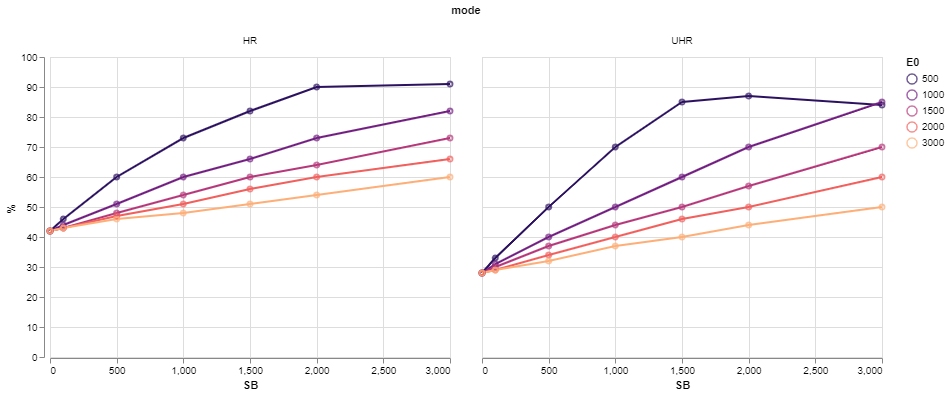

In [252]:
base = alt.Chart(df_hits).encode(
    alt.X('SB:Q', axis=alt.Axis(tickMinStep=500)),
    y='%:Q',
    color=alt.Color('E0:O', scale=alt.Scale(scheme='magma')),
)

chart = (
    base.mark_line() +\
    base.mark_point(
        size=25
    )
).facet(
    column='mode:N'
)

chart